In [46]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [47]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [48]:
df = pd.read_excel(DATA_PATH + '/Hargacabaimerahharian.xlsx')

In [49]:
df

,Tanggal,Harga Cabai Merah
0,01/ 01/ 2018,31500
1,02/ 01/ 2018,31500
2,03/ 01/ 2018,31500
3,04/ 01/ 2018,32450
4,05/ 01/ 2018,32450
...,...,...
1560,25/ 12/ 2023,62050
1561,26/ 12/ 2023,62050
1562,27/ 12/ 2023,62050
1563,28/ 12/ 2023,59850


# Statistical Analytics

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tanggal            1565 non-null   object
 1   Harga Cabai Merah  1565 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.6+ KB


In [51]:
df.shape

(1565, 2)


Statistik Deskriptif Harga:
count     1565.000000
mean     34173.386581
std      14036.722459
min      15300.000000
25%      24200.000000
50%      31800.000000
75%      39200.000000
max      95250.000000
Name: Harga Cabai Merah, dtype: float64


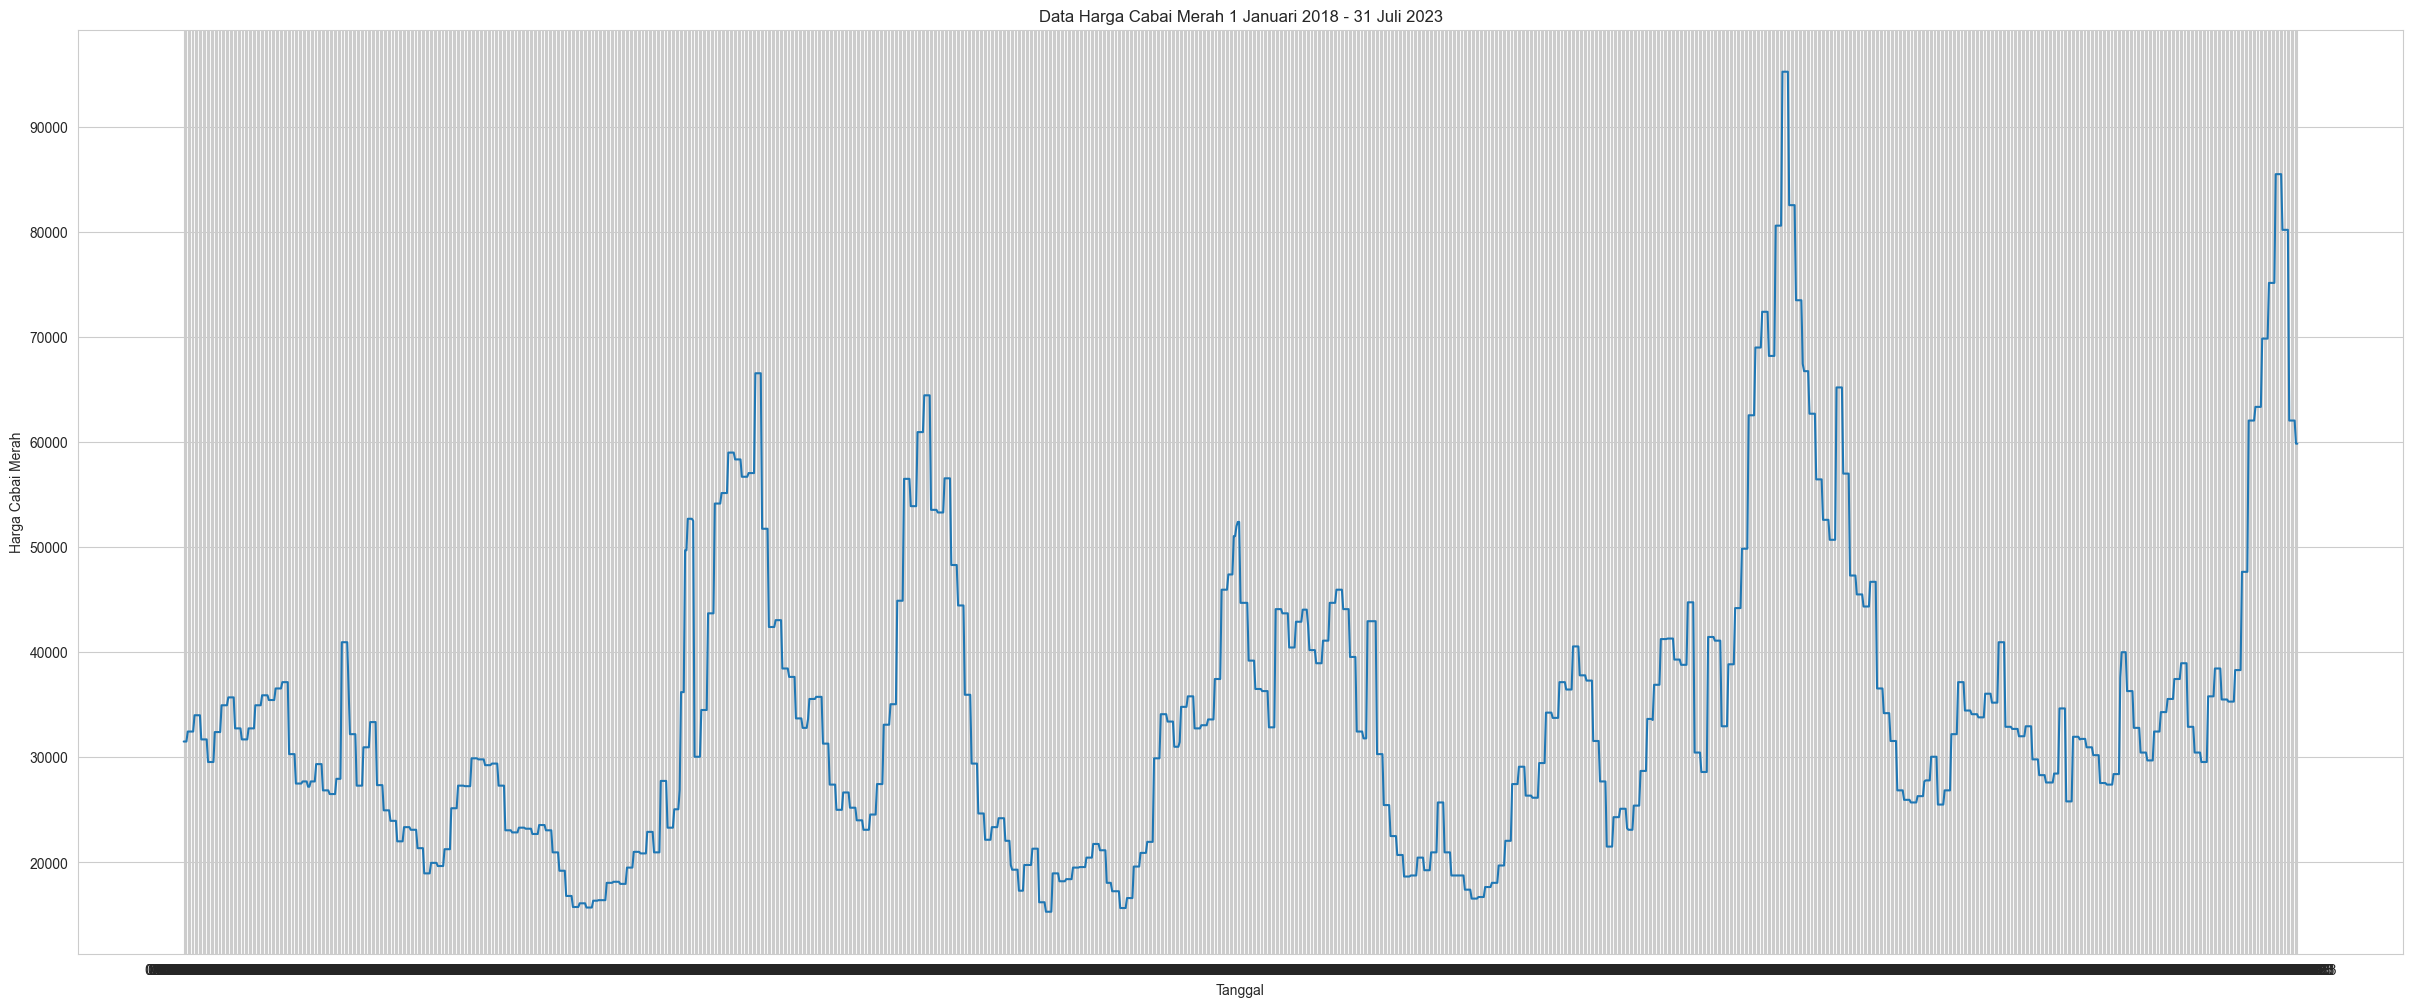

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
harga_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga:")
print(harga_stats)
plt.figure(figsize=(30, 12))
plt.plot(df['Tanggal'], df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

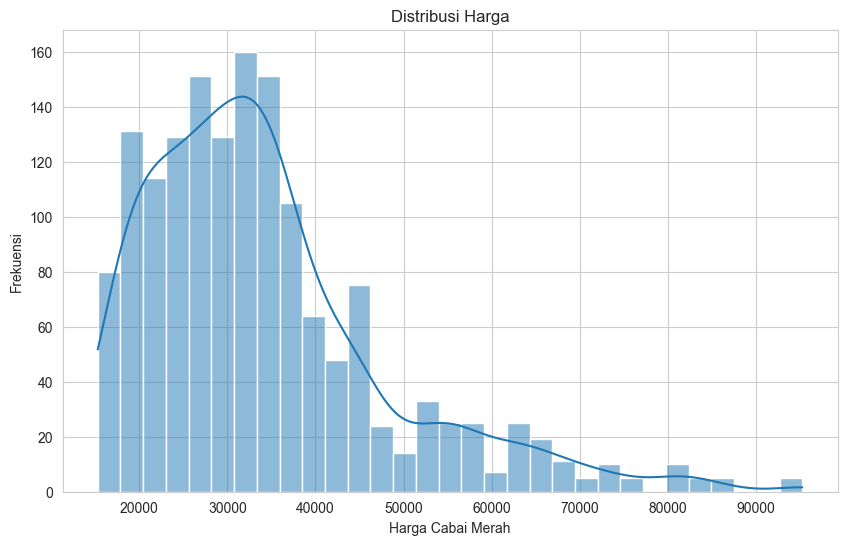

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

In [54]:
df.describe()

,Harga Cabai Merah
count,1565.000000
mean,34173.386581
std,14036.722459
min,15300.000000
25%,24200.000000
50%,31800.000000
75%,39200.000000
max,95250.000000


# Preprocessing Data


In [55]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')

In [56]:
df.isnull().sum()

Tanggal              0
Harga Cabai Merah    0
dtype: int64

In [57]:
df = df.fillna(df.mean())

C:\Users\ihsan\AppData\Local\Temp\ipykernel_15660\114435927.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [58]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])

In [59]:
df

,Tanggal,Harga Cabai Merah,Harga Cabai Merah_Scaled
0,01/ 01/ 2018,31500.0,0.202627
1,02/ 01/ 2018,31500.0,0.202627
2,03/ 01/ 2018,31500.0,0.202627
3,04/ 01/ 2018,32450.0,0.214509
4,05/ 01/ 2018,32450.0,0.214509
...,...,...,...
1560,25/ 12/ 2023,62050.0,0.584740
1561,26/ 12/ 2023,62050.0,0.584740
1562,27/ 12/ 2023,62050.0,0.584740
1563,28/ 12/ 2023,59850.0,0.557223


# Split Data

In [60]:
selected_columns = ['Harga Cabai Merah_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [61]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1), activation='relu'))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=60, batch_size=64, verbose=2)


Epoch 1/60
20/20 - 1s - loss: 0.0753 - 1s/epoch - 75ms/step
Epoch 2/60
20/20 - 0s - loss: 0.0572 - 32ms/epoch - 2ms/step
Epoch 3/60
20/20 - 0s - loss: 0.0389 - 31ms/epoch - 2ms/step
Epoch 4/60
20/20 - 0s - loss: 0.0252 - 32ms/epoch - 2ms/step
Epoch 5/60
20/20 - 0s - loss: 0.0212 - 30ms/epoch - 2ms/step
Epoch 6/60
20/20 - 0s - loss: 0.0179 - 32ms/epoch - 2ms/step
Epoch 7/60
20/20 - 0s - loss: 0.0142 - 30ms/epoch - 1ms/step
Epoch 8/60
20/20 - 0s - loss: 0.0099 - 31ms/epoch - 2ms/step
Epoch 9/60
20/20 - 0s - loss: 0.0060 - 30ms/epoch - 1ms/step
Epoch 10/60
20/20 - 0s - loss: 0.0032 - 31ms/epoch - 2ms/step
Epoch 11/60
20/20 - 0s - loss: 0.0020 - 30ms/epoch - 2ms/step
Epoch 12/60
20/20 - 0s - loss: 0.0017 - 30ms/epoch - 1ms/step
Epoch 13/60
20/20 - 0s - loss: 0.0017 - 30ms/epoch - 1ms/step
Epoch 14/60
20/20 - 0s - loss: 0.0014 - 30ms/epoch - 2ms/step
Epoch 15/60
20/20 - 0s - loss: 0.0015 - 31ms/epoch - 2ms/step
Epoch 16/60
20/20 - 0s - loss: 0.0015 - 31ms/epoch - 2ms/step
Epoch 17/60
20/20 

In [62]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

10/10 [==============================] - 0s 886us/step


In [63]:
trainY = scaler_harga.inverse_transform(trainY)

In [64]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
print(df_test)

      Actual     Predicted
0    36550.0  46056.222656
1    36550.0  36606.753906
2    36550.0  36606.753906
3    36550.0  36606.753906
4    36550.0  36606.753906
..       ...           ...
307  62050.0  61015.703125
308  62050.0  61015.703125
309  62050.0  61015.703125
310  59850.0  61015.703125
311  59850.0  58868.851562

[312 rows x 2 columns]


In [70]:
df_test.head(50)

,Actual,Predicted
0,36550.0,46056.222656
1,36550.0,36606.753906
2,36550.0,36606.753906
3,36550.0,36606.753906
4,36550.0,36606.753906
5,34200.0,36606.753906
6,34200.0,34411.644531
7,34200.0,34411.644531
8,34200.0,34411.644531
9,34200.0,34411.644531


In [66]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

# Hasil Akhir

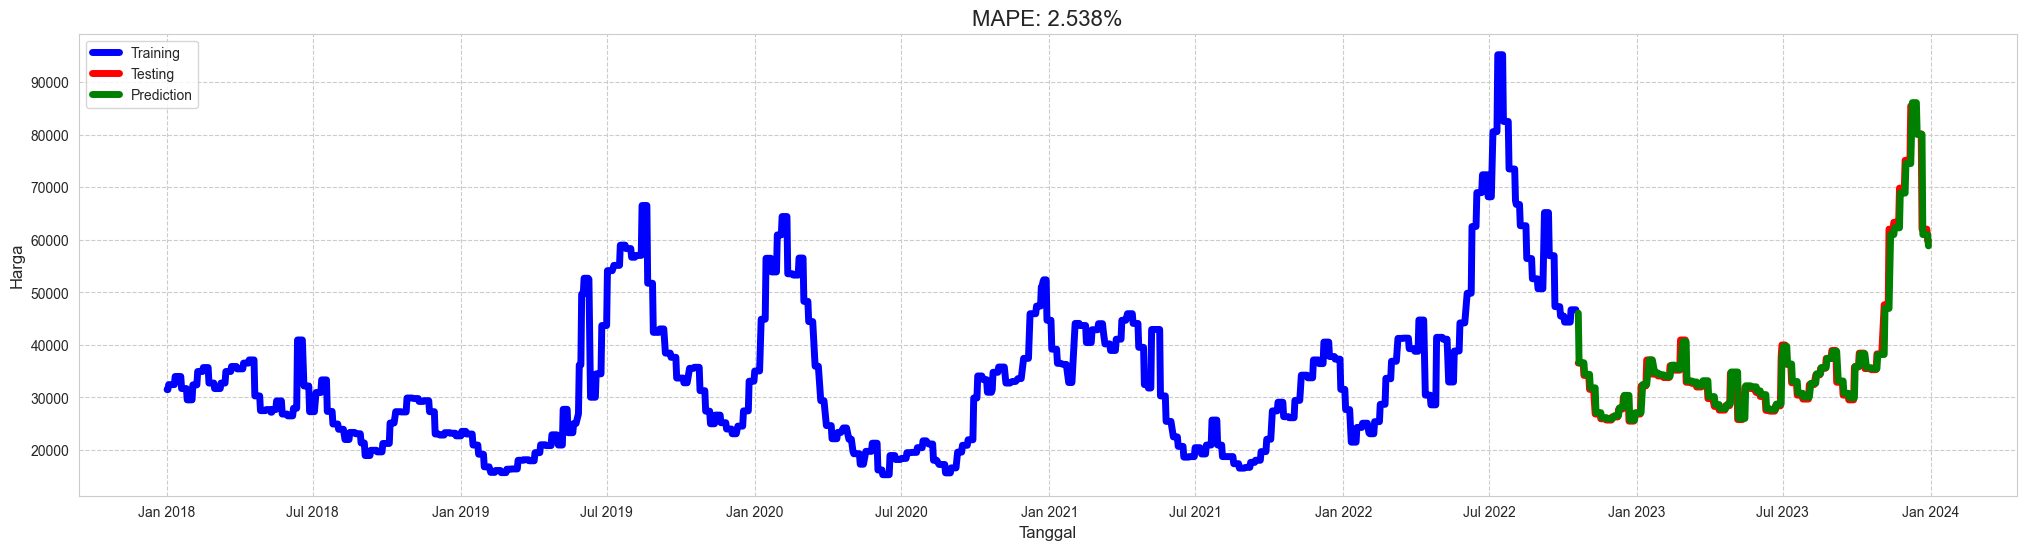

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100

plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()

locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()


In [ ]:
testX

In [ ]:
predictions = model.predict(trainX)
last_prediction = predictions[-1]
testX[0][0][0] = last_prediction

8/8 [==============================] - 0s 1ms/step


In [ ]:
testX

array([[[0.35067642, 0.11359223, 0.3518874 ]],

       [[0.25655644, 0.10582524, 0.29238644]],

       [[0.24458381, 0.1038835 , 0.21177223]],

       [[0.19669327, 0.10679612, 0.19257837]],

       [[0.14994299, 0.10194175, 0.15738964]],

       [[0.13854048, 0.1       , 0.12667946]],

       [[0.14082098, 0.08834951, 0.14075496]],

       [[0.16704675, 0.08834951, 0.15547025]],

       [[0.17217788, 0.08737864, 0.26167626]],

       [[0.15564424, 0.0961165 , 0.38067818]],

       [[0.15849487, 0.11067961, 0.34165067]],

       [[0.1995439 , 0.11941748, 0.35316699]],

       [[0.24572406, 0.11650485, 0.63403711]],

       [[0.24857469, 0.11359223, 0.58285349]],

       [[0.2331813 , 0.11359223, 0.47216891]],

       [[0.22462942, 0.11747573, 0.43122201]],

       [[0.24401368, 0.12718447, 0.41074856]],

       [[0.24344356, 0.14563107, 0.42226488]],

       [[0.31812999, 0.14466019, 0.45041587]],

       [[0.28335234, 0.15145631, 0.52911068]],

       [[0.23717218, 0.17961165, 0.49328

In [ ]:
testX[:1]

array([[[0.34386265, 0.11359223, 0.3518874 ]]])

In [ ]:
prediksi_testX_pertama = model.predict(testX[:1])
testX[1][0][0] = prediksi_testX_pertama

1/1 [==============================] - 0s 15ms/step


In [ ]:
testX

array([[[0.34386265, 0.11359223, 0.3518874 ]],

       [[0.31132954, 0.10582524, 0.29238644]],

       [[0.24458381, 0.1038835 , 0.21177223]],

       [[0.19669327, 0.10679612, 0.19257837]],

       [[0.14994299, 0.10194175, 0.15738964]],

       [[0.13854048, 0.1       , 0.12667946]],

       [[0.14082098, 0.08834951, 0.14075496]],

       [[0.16704675, 0.08834951, 0.15547025]],

       [[0.17217788, 0.08737864, 0.26167626]],

       [[0.15564424, 0.0961165 , 0.38067818]],

       [[0.15849487, 0.11067961, 0.34165067]],

       [[0.1995439 , 0.11941748, 0.35316699]],

       [[0.24572406, 0.11650485, 0.63403711]],

       [[0.24857469, 0.11359223, 0.58285349]],

       [[0.2331813 , 0.11359223, 0.47216891]],

       [[0.22462942, 0.11747573, 0.43122201]],

       [[0.24401368, 0.12718447, 0.41074856]],

       [[0.24344356, 0.14563107, 0.42226488]],

       [[0.31812999, 0.14466019, 0.45041587]],

       [[0.28335234, 0.15145631, 0.52911068]],

       [[0.23717218, 0.17961165, 0.49328

In [ ]:
testX[2]

array([[0.24458381, 0.1038835 , 0.21177223]])

In [ ]:
testX[1]

array([[0.31132954, 0.10582524, 0.29238644]])

In [ ]:
prediksi_testX_kedua = model.predict(testX[1:2])
testX[2][0][0] = prediksi_testX_kedua

1/1 [==============================] - 0s 17ms/step


In [ ]:
for i in range(len(testX)):
    if i == 0:
        prediksi = model.predict(testX[:1])
    else:
        prediksi = model.predict(testX[i:i+1])
    if i+1 < len(testX):
        testX[i+1][0][0] = prediksi


1/1 [==============================] - 0s 14ms/step


IndexError: index 62 is out of bounds for axis 0 with size 62

In [ ]:
testX

array([[[0.34386265, 0.11359223, 0.3518874 ]],

       [[0.31132954, 0.10582524, 0.29238644]],

       [[0.2802017 , 0.1038835 , 0.21177223]],

       [[0.25094593, 0.10679612, 0.19257837]],

       [[0.22713327, 0.10194175, 0.15738964]],

       [[0.20716441, 0.1       , 0.12667946]],

       [[0.19092306, 0.08834951, 0.14075496]],

       [[0.17871457, 0.08834951, 0.15547025]],

       [[0.17006531, 0.08737864, 0.26167626]],

       [[0.1660955 , 0.0961165 , 0.38067818]],

       [[0.16571099, 0.11067961, 0.34165067]],

       [[0.16520679, 0.11941748, 0.35316699]],

       [[0.16532555, 0.11650485, 0.63403711]],

       [[0.16927439, 0.11359223, 0.58285349]],

       [[0.17187431, 0.11359223, 0.47216891]],

       [[0.17240465, 0.11747573, 0.43122201]],

       [[0.17227623, 0.12718447, 0.41074856]],

       [[0.17214862, 0.14563107, 0.42226488]],

       [[0.17286941, 0.14466019, 0.45041587]],

       [[0.17387772, 0.15145631, 0.52911068]],

       [[0.17610618, 0.17961165, 0.49328

In [ ]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 0s 3ms/step


In [ ]:
trainY = scaler_harga.inverse_transform(trainY)